# Test of Doppler lags for the observed oscillations
    
Following tests are scripted for comprehensive characterization
- convergence to reference orbit with zero lags
- impact of a uniform lag in the Doppler (range rate) data
- impact of light-time lags, i.e., radial acceleration and light time
- impact of light-time lags times a scale factor


In [1]:
from astropy import units as u
sampling_interval = 1*u.hour
tracking_period = 30*u.day

In [2]:
from astropy import constants as const
from astropy import visualization
from astropy.coordinates import solar_system_ephemeris
    
from poliastro.util import norm
from poliastro.twobody.sampling import EpochsArray
    
import numpy as np
import sys
sys.path.append('../')
    
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
    
from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import orbit_from_horizons, make_epochs, find_rates
from sim.util import describe_orbit, describe_trajectory, plot_residual, plot_swings
from sim.fitorbit import OrbitFitter
    
def plots(epochs, residual, title, ylab):
    plot_residual(epochs, residual, title, 'Residual ' + ylab)
    try:
        plot_swings(epochs, residual, None, 'Residual swings ' + ylab)
    except ValueError:
        # no swings identified
        pass
    
def fitv(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_doppler_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'doppler (m/s)')
    return fitter
    
def reusefitv(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.doppler_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'doppler (m/s)')
    return residual
    
def fitr(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_range_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'range (m)')
    rates = find_rates(epochs, fitter.result.residual)
    plots(epochs[1:], rates, None, 'range rate (m/s)')
    return fitter, rates
    
def reusefitr(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.range_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'range (m)')
    rates = find_rates(epochs, residual)
    plots(epochs[11:], rates[10:], None, 'range rate (m/s)')
    return rates

In [3]:
solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
    
near_goldstone_orbit = orbit_from_horizons("NEAR", goldstone_end)
describe_orbit(near_goldstone_orbit)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + tracking_period
epochs = make_epochs(canberra_start, canberra_end, sampling_interval)
print("Start and end:", epochs[0], epochs[-1], "[", epochs.size, "]")
    
near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(epochs))
describe_trajectory(near_extended_ephem, dss34)

Start and end: 1998-01-23 09:53:55.600 1998-02-22 08:53:55.600 [ 720 ]

::TRAJECTORY::
Start and end ranges: 99245.7532096098 km 17847093.095720734 km
Start and end radial speeds: 7.3216176182785535 km / s 6.742051287016325 km / s
Closest: 73145.82143191747 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.457927625040083 deg


In [5]:
vdata_ref = []
vlags = []
vlags_full = []
vdata_constvlags = []
vdata_ltlags_full = []
vdata_ltlags = []
vdata_scaledlags = []
    
rdata_ref = []
rlags = []
rlags_full = []
rdata_constrlags = []
rdata_ltlags_full = []
rdata_ltlags = []
rdata_scaledlags = []
    
scalefactor = 0.1
first_vlag = None
first_rlag = None
    
for e in epochs[:-1]:
    ref_r, ref_rr, ref_ra, ref_rs = dss34.range_rate_accel(near_extended_ephem, e)
    print(e.strftime("%H:%M:%S"),
         ref_r.to_value(u.km),
         ref_ra.to_value(u.m/(u.s*u.s)),
         ref_rs.to_value(u.m/(u.s*u.s)),
         (ref_ra+ref_rs).to_value(u.m/(u.s*u.s)),
         )
    
    vlag_full = ref_ra*ref_r/const.c
    vlag = (ref_ra+ref_rs)*ref_r/const.c
    
    if first_vlag is None:
        first_vlag = vlag
    
    vlags.append(vlag)
    vlags_full.append(vlag_full)
    
    vdata_ref.append([ref_rr])
    vdata_constvlags.append([ref_rr - first_vlag])
    vdata_ltlags_full.append([ref_rr - vlag_full])
    vdata_ltlags.append([ref_rr - vlag])
    vdata_scaledlags.append([ref_rr - scalefactor*vlag])
    
for e in epochs:
    rv = near_extended_ephem.rv(e)
    ref_r, ref_rr, ref_rs = dss34.range_and_rates(rv, e)
    print(e.strftime("%H:%M:%S"),
         ref_r.to_value(u.km),
         ref_rr.to_value(u.m/u.s),
         ref_rs.to_value(u.m/u.s),
         (ref_rr+ref_rs).to_value(u.m/u.s),
         )
    
    rlag_full = ref_rr*ref_r/const.c
    rlag = (ref_rr+ref_rs)*ref_r/const.c
    
    if first_rlag is None:
        first_rlag = rlag
    
    rlags.append(rlag)
    rlags_full.append(rlag_full)
    
    rdata_ref.append([ref_r])
    rdata_constrlags.append([ref_r - first_rlag])
    rdata_ltlags_full.append([ref_r - rlag_full])
    rdata_ltlags.append([ref_r - rlag])
    rdata_scaledlags.append([ref_r - scalefactor*rlag])

09:53:55 73145.82143191747 -0.04185589375538257 0.01192843359500273 -0.029927460160379837
10:53:55 99245.7532096098 -0.03059583885089978 0.00693192085350347 -0.02366391799739631
11:53:55 124953.15770282669 -0.019042220756659844 0.003217205848670801 -0.015825014907989043
12:53:55 150407.26865298714 -0.011860758101001068 2.649666981824339e-06 -0.011858108434019243
13:53:55 175706.3273609694 -0.0061811455198679255 -0.002839522583883536 -0.009020668103751461
14:53:55 200923.61747138412 -0.0019067205281331212 -0.0052638765777146546 -0.007170597105847777
15:53:55 226115.081514972 0.0013292310754309256 -0.00718074742607655 -0.005851516350645625
16:53:55 251322.7147374973 0.0036045875928536475 -0.008504513680904324 -0.004899926088050678
17:53:55 276576.09410904173 0.004988653794057996 -0.00917620543836506 -0.004187551644307065
18:53:55 301893.2139723953 0.005533782702293877 -0.009174524770680037 -0.003640742068386161
19:53:55 327281.2187505763 0.005310967222449392 -0.008520129656403697 -0.0032

14:53:55 2588743.617146506 0.006053082967305556 -0.006107401231503218 -5.431826419766173e-05
15:53:55 2613228.315979765 0.007418314467599885 -0.007471117123252213 -5.28026556523286e-05
16:53:55 2637808.5975996307 0.008269981785602454 -0.008321655777510983 -5.1673991908530144e-05
17:53:55 2662495.4370598304 0.008549464323159839 -0.008600378944833231 -5.0914621673392256e-05
18:53:55 2687292.436792106 0.008237652638243276 -0.008288135473264902 -5.0482835021626736e-05
19:53:55 2712195.580307736 0.007356269764002832 -0.007406588795667801 -5.031903166496943e-05
20:53:55 2737193.511970566 0.00596631707683315 -0.006016669686204068 -5.0352609370918175e-05
21:53:55 2762268.322841211 0.004163768865694806 -0.004214277337197814 -5.050847150300766e-05
22:53:55 2787396.7871512296 0.0020728435341510476 -0.002123555973369662 -5.071243921861424e-05
23:53:55 2812551.9627528093 -0.00016264813762489894 0.00011175300411991884 -5.0895133504980095e-05
00:53:55 2837705.044099516 -0.0023892498068889267 0.002338

21:53:55 5135040.222336366 0.0036171408552831963 -0.00363188137359316 -1.4740518309963513e-05
22:53:55 5160144.39777782 0.0014739026283905332 -0.0014888217918809232 -1.4919163490389948e-05
23:53:55 5185267.568987766 -0.0007708214422308401 0.0007557319204352098 -1.5089521795630403e-05
00:53:55 5210380.811142196 -0.002963160287805522 0.0029479271146470865 -1.5233173158435217e-05
01:53:55 5235455.874003927 -0.004952977450400908 0.004937643734223229 -1.5333716177679136e-05
02:53:55 5260467.116596762 -0.006604124493492236 0.006588747275984019 -1.537721750821695e-05
03:53:55 5285393.261683401 -0.007803708041542734 0.0077883552454238725 -1.5352796118860924e-05
04:53:55 5310218.850605812 -0.008469752618367465 0.00845449936748821 -1.5253250879254204e-05
05:53:55 5334935.299733168 -0.008556754101718411 0.008541678302817601 -1.5075798900809114e-05
06:53:55 5359541.486923974 -0.008058760204932014 0.008043937466361228 -1.4822738570785383e-05
07:53:55 5384043.828301918 -0.007009776638255971 0.006995

05:53:55 7705466.39382493 -0.008467945808554589 0.008460717882922353 -7.227925632235645e-06
06:53:55 7730031.617376387 -0.007815900004537468 0.00780878140543706 -7.118599100407842e-06
07:53:55 7754496.124916323 -0.006628933320484975 0.00662195650224362 -6.976818241354916e-06
08:53:55 7778875.210676567 -0.00498821830152707 0.004981409015854865 -6.809285672204705e-06
09:53:55 7803190.015957705 -0.003006006469519207 0.0029993814961954968 -6.624973323710081e-06
10:53:55 7827466.082686462 -0.0008179852581946534 0.0008115508116190995 -6.434446575553878e-06
11:53:55 7851731.60496601 0.0014259805762861788 -0.0014322295376700822 -6.2489613839033725e-06
12:53:55 7876015.497959056 0.0035720993167842607 -0.0035781787178450486 -6.079401060788123e-06
13:53:55 7900345.416176976 0.005473197099092886 -0.005479132361216443 -5.935262123557997e-06
14:53:55 7924745.857039344 0.006998832936311317 -0.007004656719985292 -5.823783673975216e-06
15:53:55 7949236.480060915 0.008044282710173434 -0.0080500320704146

12:53:55 10245578.045768915 0.0041106012700353745 -0.004114180447388094 -3.5791773527193575e-06
13:53:55 10269918.548030274 0.0059227070696721285 -0.005926210323181635 -3.5032535095071455e-06
14:53:55 10294335.365561781 0.007328701935094273 -0.007332149196592752 -3.447261498479801e-06
15:53:55 10318846.616328273 0.008232107427730284 -0.008235520873029145 -3.4134452988605457e-06
16:53:55 10343463.942219688 0.008570920775774482 -0.008574323028347042 -3.4022525725594982e-06
17:53:55 10368191.710110683 0.00832189034394304 -0.008325302751700292 -3.412407757253012e-06
18:53:55 10393026.712133413 0.0075021187129209466 -0.007505559916957338 -3.4412040363917214e-06
19:53:55 10417958.38602231 0.006167881020147092 -0.0061713658704718455 -3.484850324753219e-06
20:53:55 10442969.540130768 0.004410742140414925 -0.004414281013765731 -3.5388733508053973e-06
21:53:55 10468037.533234436 0.0023512460307628658 -0.0023548444885648223 -3.598457801956468e-06
22:53:55 10493135.827729428 0.00013061937487179875

19:53:55 12787211.396944977 0.005739546131700024 -0.005741871840427848 -2.325708727823691e-06
20:53:55 12812236.259588158 0.0038899670178338397 -0.0038923318972905463 -2.364879456706976e-06
21:53:55 12837311.250892214 0.0017738045867687902 -0.0017762115910073817 -2.40700423859157e-06
22:53:55 12862409.102959063 -0.00046386527952080314 0.00046141640068242396 -2.448878838379161e-06
23:53:55 12887500.981861979 -0.0026696948864923797 0.0026672074653362188 -2.4874211561610915e-06
00:53:55 12912558.463612856 -0.004692576395015635 0.004690056619409688 -2.5197756059468595e-06
01:53:55 12937555.481331635 -0.006393984455677071 0.006391441045266788 -2.54341041028254e-06
02:53:55 12962470.110310221 -0.007657444350606113 0.007654888130488757 -2.5562201173561937e-06
03:53:55 12987286.068937907 -0.008396483306860603 0.008393926665121398 -2.556641739203465e-06
04:53:55 13011993.833094629 -0.008560528231171816 0.008557984419032216 -2.5438121395991617e-06
05:53:55 13036591.287870832 -0.00813835308122179

03:53:55 15356161.452633508 -0.008495530802399287 0.008493701217917149 -1.8295844821373841e-06
04:53:55 15380837.52358437 -0.008504279453092067 0.008502460433948755 -1.8190191433113976e-06
05:53:55 15405404.009782467 -0.007930586872539891 0.007928787855270514 -1.7990172693766577e-06
06:53:55 15429868.30270973 -0.006813716645126533 0.006811946259105639 -1.7703860208934103e-06
07:53:55 15454244.793245519 -0.005230118095944647 0.005228383463816044 -1.7346321286022302e-06
08:53:55 15478553.88657123 -0.0032882097453779124 0.0032865158677424233 -1.693877635489055e-06
09:53:55 15502820.605191197 -0.0011209753152385815 0.0011193245977096922 -1.6507175288892501e-06
10:53:55 15527072.875294238 0.0011231271610512295 -0.0011247351608574263 -1.6079998061968734e-06
11:53:55 15551339.613800453 0.0032903259494787562 -0.003291894511065152 -1.5685615863957227e-06
12:53:55 15575648.746887313 0.00523207294111927 -0.005233607895405612 -1.5349542863423056e-06
13:53:55 15600025.295840286 0.006815235443546896

16:53:55 251322.7147374973 7007.379229306495 54.90520121159005 7062.284430518085
17:53:55 276576.09410904173 7023.105801442162 22.879163338189827 7045.984964780352
18:53:55 301893.2139723953 7042.287322157354 -10.353411101246321 7031.933911056107
19:53:55 327281.2187505763 7062.02518157836 -42.39282624158386 7019.6323553367765
20:53:55 352737.32525912847 7079.717672930693 -70.98897839406094 7008.728694536632
21:53:55 378250.0595811803 7093.154216062146 -94.18350224896248 6998.970713813183
22:53:55 403800.8309381831 7100.605365786628 -110.43116487724247 6990.174200909385
23:53:55 429365.7992592991 7100.894056308033 -118.6920728952534 6982.20198341278
00:53:55 454917.9512069915 7093.439034199435 -118.48927391523723 6974.9497602841975
01:53:55 480429.27459660143 7078.26556206318 -109.9291120049425 6968.3364500582375
02:53:55 505872.9095127604 7055.981726213679 -93.68417247899346 6962.2975537346865
03:53:55 531225.1533102376 7027.721304679207 -70.94079456924413 6956.780510109962
04:53:55 5

20:53:55 2737193.511970566 6955.513080107106 -84.14125949782577 6871.371820609281
21:53:55 2762268.322841211 6973.854615035983 -102.66431992920289 6871.1902951067805
22:53:55 2787396.7871512296 6985.1473182299005 -114.13921799008092 6871.00810023982
23:53:55 2812551.9627528093 6988.6073814314495 -117.78219187115074 6870.825189560298
00:53:55 2837705.044099516 6983.989185094649 -113.3474312041555 6870.641753890494
01:53:55 2862827.339612924 6971.601126391596 -101.14293417195657 6870.458192219639
02:53:55 2887892.2376337647 6952.283531735762 -82.00845361507196 6870.2750781206905
03:53:55 2912877.0268648346 6927.350403389809 -57.257281117976504 6870.093122271833
04:53:55 2937764.4478836968 6898.49914315001 -28.586012847538935 6869.9131303024715
05:53:55 2962543.871071633 6867.694469092313 2.041485772566859 6869.73595486488
06:53:55 2987212.021779326 6837.034384563155 32.52805711276492 6869.56244167592
07:53:55 3011773.2040457963 6808.607192530815 60.786178500423944 6869.393371031239
08:53

00:53:55 5210380.811142196 6971.8627329411775 -110.50006054004656 6861.362672401131
01:53:55 5235455.874003927 6957.5324617144815 -96.22482511840813 6861.307636596073
02:53:55 5260467.116596762 6936.6104572707945 -75.35811954284388 6861.252337727951
03:53:55 5285393.261683401 6910.527313198868 -49.33031147378663 6861.1970017250815
04:53:55 5310218.850605812 6881.0664091175995 -19.924521822146954 6861.141887295453
05:53:55 5334935.299733168 6850.241916952403 10.845354375034168 6861.087271327437
06:53:55 5359541.486923974 6820.161179309915 40.872252435117446 6861.0334317450315
07:53:55 5384043.828301918 6792.88077580987 68.09985260988718 6860.980628419757
08:53:55 5408455.840097473 6770.266007957692 90.66307549849144 6860.9290834561825
09:53:55 5432797.215155585 6753.863316912653 107.01564585922821 6860.878962771882
10:53:55 5457092.476623639 6744.794310972187 116.03605022041741 6860.830361192605
11:53:55 5481369.300187828 6743.678664863317 117.1046282923488 6860.783293155667
12:53:55 55

07:53:55 7754496.124916323 6782.9772926529195 74.72350364922393 6857.700796302143
08:53:55 7778875.210676567 6761.944791727474 95.73118288836125 6857.675974615835
09:53:55 7803190.015957705 6747.471050563725 110.18073865644956 6857.651789220175
10:53:55 7827466.082686462 6740.547002915322 117.08127894531451 6857.628281860637
11:53:55 7851731.60496601 6741.6466325181855 115.95882218807736 6857.605454706263
12:53:55 7876015.497959056 6750.694184494709 106.88908526060872 6857.583269755318
13:53:55 7900345.416176976 6767.0690238460475 90.4926281774122 6857.56165202346
14:53:55 7924745.857039344 6789.6478985210715 67.89259766518576 6857.540496186257
15:53:55 7949236.480060915 6816.881783333561 40.637892522072384 6857.519675855633
16:53:55 7973830.757401171 6846.902073806807 10.596980522783916 6857.499054329592
17:53:55 7998535.048892656 6877.6488409827525 -20.170345450041996 6857.47849553271
18:53:55 8023348.165364187 6907.0123030286995 -49.554429053109516 6857.457873975591
19:53:55 8048261

13:53:55 10269918.548030274 6770.876676942069 84.99546496079269 6855.872141902862
14:53:55 10294335.365561781 6794.86655316589 60.993084119608476 6855.859637285499
15:53:55 10318846.616328273 6823.037678318982 32.80961642084742 6855.8472947398295
16:53:55 10343463.942219688 6853.4580318890685 2.3770012001089573 6855.835033089176
17:53:55 10368191.710110683 6884.041222749734 -28.21845004189663 6855.8227727078365
18:53:55 10393026.712133413 6912.689707275162 -56.879266046092376 6855.8104412290695
19:53:55 10417958.38602231 6937.438771792324 -81.64079369392185 6855.7979780984015
20:53:55 10442969.540130768 6956.591346015268 -100.80600826154996 6855.785337753718
21:53:55 10468037.533234436 6968.834360611288 -113.06186916188193 6855.772491449406
22:53:55 10493135.827729428 6973.328657990401 -117.56923007667378 6855.7594279137265
23:53:55 10518235.80939481 6969.766313496267 -114.02016039204808 6855.746153104219
00:53:55 10543308.748655805 6958.391488112145 -102.6587988092754 6855.73268930286

18:53:55 12762260.49544372 6918.659199738994 -63.88512743133207 6854.774072307662
19:53:55 12787211.396944977 6942.078073751825 -87.31231229998042 6854.765761451845
20:53:55 12812236.259588158 6959.5123841590075 -104.7550644201566 6854.757319738852
21:53:55 12837311.250892214 6969.767183855233 -115.01845313153241 6854.748730723701
22:53:55 12862409.102959063 6972.139811546987 -117.39982198976202 6854.739989557225
23:53:55 12887500.981861979 6966.467874217057 -111.73677147002299 6854.731102747035
00:53:55 12912558.463612856 6953.1401678596385 -98.41808035075441 6854.722087508884
01:53:55 12937555.481331635 6933.069843699186 -78.35687291840942 6854.712970780776
02:53:55 12962470.110310221 6907.631709892536 -52.927922002075 6854.70378789046
03:53:55 12987286.068937907 6878.567998456429 -23.87341764795536 6854.694580808475
04:53:55 13011993.833094629 6847.8690611773945 6.816334732070159 6854.685395909465
05:53:55 13036591.287870832 6817.6371477991 37.039133415223304 6854.676281214322
06:53

00:53:55 15281513.83545812 6947.7466926851885 -93.72200697412283 6854.024685711066
01:53:55 15306488.509042487 6926.113284981758 -72.09513348696655 6854.018151494792
02:53:55 15331375.910691861 6899.540959744343 -45.52938642521992 6854.011573319123
03:53:55 15356161.452633508 6869.849772615536 -15.844790452424743 6854.004982163111
04:53:55 15380837.52358437 6839.073253395904 14.925158356554089 6853.998411752458
05:53:55 15405404.009782467 6809.31921512809 44.67268136801066 6853.9918964961
06:53:55 15429868.30270973 6782.625495411904 71.35997371177717 6853.985469123681
07:53:55 15454244.793245519 6760.820468280059 93.15868990935316 6853.979158189412
08:53:55 15478553.88657123 6745.397844803159 108.57514088339329 6853.972985686552
09:53:55 15502820.605191197 6737.414318901976 116.55264615619424 6853.96696505817
10:53:55 15527072.875294238 6737.417072819734 116.54402705857271 6853.961099878306
11:53:55 15551339.613800453 6745.40613371595 108.5492496934231 6853.955383409374
12:53:55 155756

04:53:55 17749470.295173608 6830.548077185437 22.946589458619968 6853.494666644056
05:53:55 17774007.042284124 6801.411904229268 52.07787858569246 6853.489782814961
06:53:55 17798444.751816887 6775.843433919969 77.64153496557617 6853.484968885546
07:53:55 17822799.512550116 6755.594135927058 97.8861093781696 6853.480245305228
08:53:55 17847093.095720734 6742.051287016326 111.42434017008131 6853.475627186406


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 719
    # variables        = 6
    chi-square         = 1.8991e-04
    reduced chi-square = 2.6635e-07
    Akaike info crit   = -10878.5773
    Bayesian info crit = -10851.1101
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83945089 (init = -1.839425)
    raan:  1.54004127 (init = 1.540059)
    argp:  2.53325285 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:47.420613

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.000

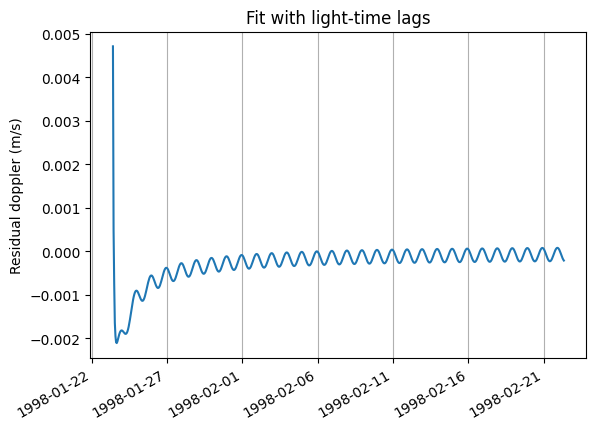

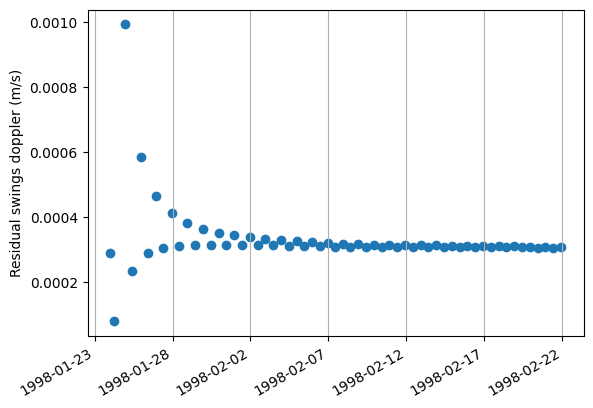

In [6]:
ltfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ltlags, "Fit with light-time lags")

[0.0028285472136405504, 0.0028266812053820145, 0.002828022051188747, 0.0028248508978221815]


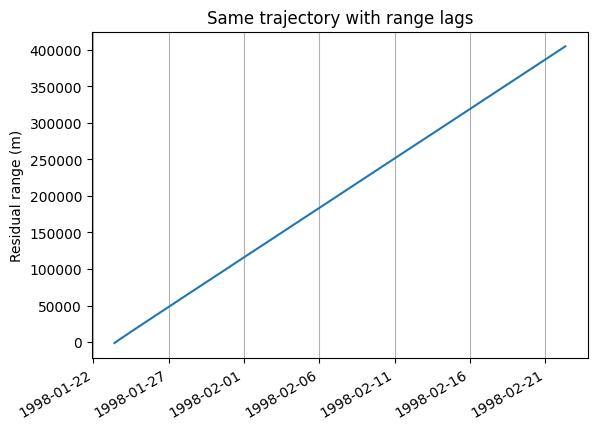

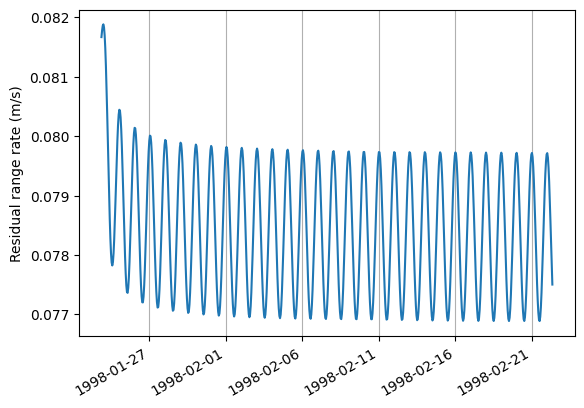

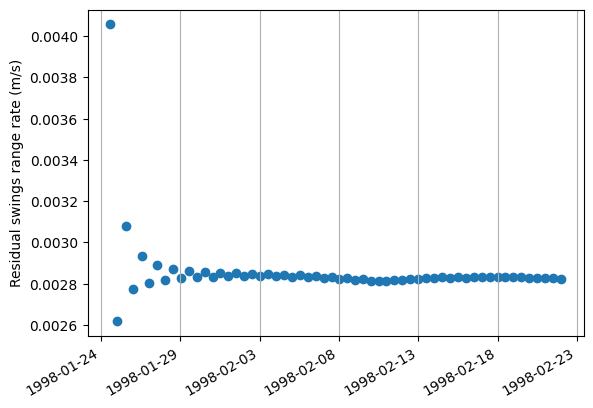

In [7]:
_ = ltresr_rates = reusefitr(ltfitv, epochs[:-1], rdata_ltlags, "Same trajectory with range lags")

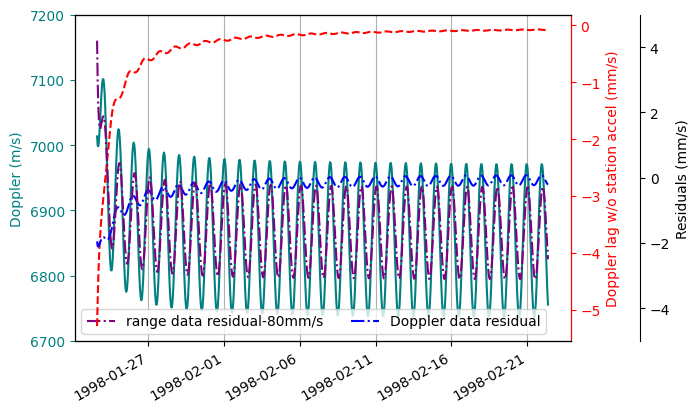

In [9]:
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('')
    plt.grid(axis='x')

    if tracking_period > 5*u.day:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

    ax.set_ylabel('Doppler (m/s)', color = "teal")
    ax.spines['left'].set(color="teal")
    ax.tick_params(axis="y", colors="teal")
    ax.set_ylim([6700, 7200])
            
    ax2 = ax.twinx()
    ax2.set_ylabel('Doppler lag w/o station accel (mm/s)', color = "red")
    ax2.spines['right'].set(color="red")
    ax2.tick_params(axis="y", colors="red")

    ax3 = ax.twinx()
    ax3.set_ylabel('Residuals (mm/s)', color = "black")
    ax3.spines['right'].set_position(('outward', 50))
    ax3.set_ylim([-5, 5])

    p1, = ax.plot(epochs[5:], [v[0].to_value(u.m/u.s) for v in vdata_ref[4:]], 
                  color="teal", label="Doppler")
    p2, = ax2.plot(epochs[5:], [v.to_value(u.mm/u.s) for v in vlags[4:]],
                   linestyle = "dashed", color="red", label="lag w/o station accel")
    
    p3, = ax3.plot(epochs[5:], [1e3*v for v in ltfitv.result.residual[4:]],
                   linestyle='-.', color="blue", label="Doppler data residual")
    p4, = ax3.plot(epochs[5:], [1e3*v-80 for v in ltresr_rates[3:]],
                   linestyle='-.', color="purple", label="range data residual-80mm/s")

    ax.legend(handles=[p4, p3], loc="lower left", ncol=2)
    plt.gcf().autofmt_xdate()

    plt.savefig(f'near_sim_postencounter-{int(tracking_period.to_value(u.day))}d.pdf', bbox_inches='tight')